In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import os
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats
from functools import reduce
import statsmodels
import seaborn as sns
import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, savefig, despine
from tqdm.notebook import tqdm
tqdm.pandas()
from scipy.interpolate import interp1d
from septum_mec.analysis.statistics import (
    load_data_frames, 
    make_paired_tables, 
    make_statistics_table, 
    estimate_power_lmm, 
    estimate_power_lmm_paralell, 
    LMM, 
    estimate_sample_size_lmm, 
    estimate_sample_size_lmm_paralell
)

In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-power-re_formula"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
(output_path / "data").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
data, labels, colors, queries = load_data_frames()

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


# Calculate statistics

In [5]:
columns = [
    'average_rate', 
    'gridness', 
    'information_specificity',
    'max_rate', 
    'information_rate', 
    'in_field_mean_rate', 
    'out_field_mean_rate', 
    'speed_score', 
    'spacing', 
    'field_area'

]

In [6]:
results, labels = make_paired_tables(data, columns)

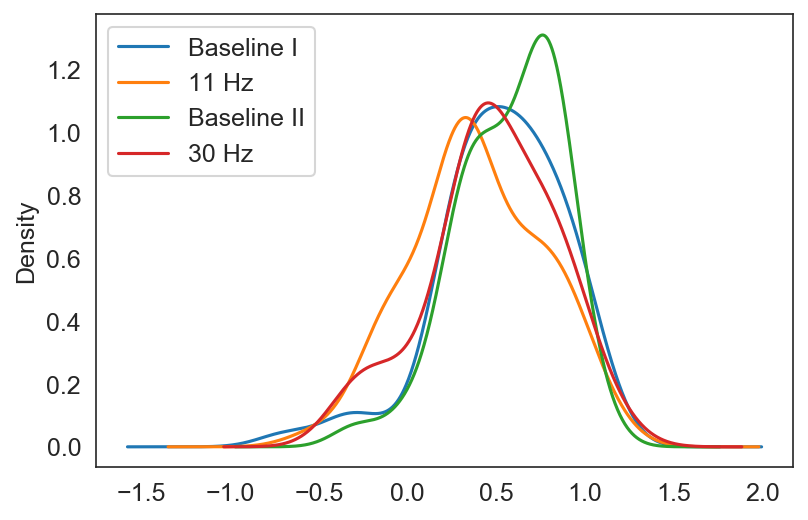

In [7]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

results['gridcell']['gridness'][labels].plot.density()

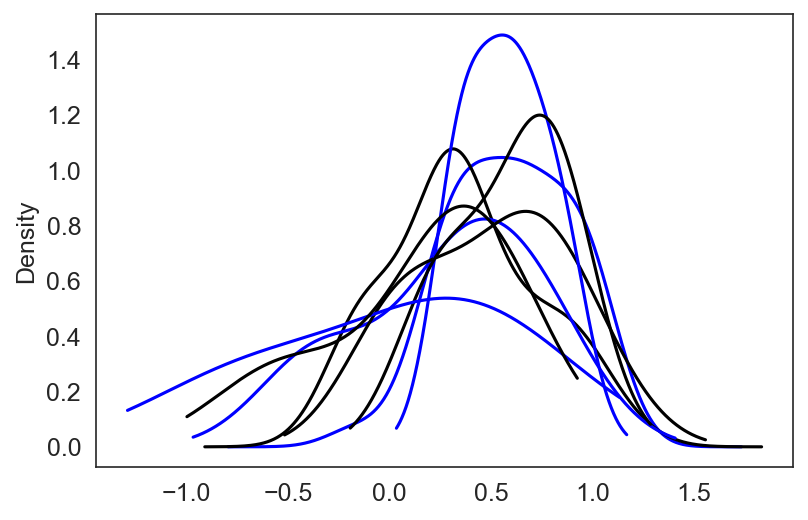

In [19]:
for e, g, in results['gridcell']['gridness'].groupby('entity'):
    g['Baseline I'].plot.density(color='b')
    g['11 Hz'].plot.density(color='k')

In [8]:
summary = pd.DataFrame()
for key, df in results['gridcell'].items():
    Key = key.replace('_', ' ').capitalize()
    for label in labels:
        summary.loc[label, Key] = "{:.3f} ± {:.3f}".format(df[label].mean(), df[label].std())
summary.T

,Baseline I,11 Hz,Baseline II,30 Hz
Average rate,9.040 ± 6.369,8.934 ± 6.545,8.368 ± 6.154,7.553 ± 5.359
Gridness,0.527 ± 0.353,0.393 ± 0.369,0.579 ± 0.287,0.479 ± 0.355
Information specificity,0.245 ± 0.229,0.208 ± 0.264,0.218 ± 0.177,0.226 ± 0.209
Max rate,37.533 ± 15.081,32.799 ± 14.292,37.684 ± 16.860,34.584 ± 12.544
Information rate,1.324 ± 0.617,0.906 ± 0.543,1.177 ± 0.640,0.983 ± 0.555
In field mean rate,14.973 ± 8.381,13.344 ± 8.073,14.126 ± 7.835,12.109 ± 6.060
Out field mean rate,6.389 ± 5.358,6.712 ± 5.898,5.787 ± 5.225,5.265 ± 4.488
Speed score,0.142 ± 0.081,0.105 ± 0.090,0.120 ± 0.060,0.104 ± 0.073
Spacing,0.439 ± 0.121,0.456 ± 0.123,0.416 ± 0.093,0.424 ± 0.080
Field area,0.431 ± 0.053,0.417 ± 0.051,0.423 ± 0.051,0.431 ± 0.052


In [9]:
vss = [
    ('Baseline I', '11 Hz'),
    ('Baseline I', 'Baseline II'),
    ('Baseline II', '30 Hz'),
]

In [12]:

ps = pd.DataFrame()
ci = pd.DataFrame()
ef = pd.DataFrame()
mf = pd.DataFrame()
for key, df in results['gridcell'].items():
    Key = key.replace('_', ' ').capitalize()
    for vs in vss:
        pval, low, high, mdf = LMM(df, *vs, key, use_unit_id=False, re_formula='label')
        ps.loc[f'LMM {vs[0]} - {vs[1]}', key] = pval
        ci.loc[f'LMM {vs[0]} - {vs[1]}', key] = f'{low}, {high}'
        ef.loc[f'LMM {vs[0]} - {vs[1]}', key] = mdf.params[1]
        mf.loc[f'LMM {vs[0]} - {vs[1]}', key] = abs(df[vs[0]].mean() - df[vs[1]].mean())

In [13]:
ps

,average_rate,gridness,information_specificity,max_rate,information_rate,in_field_mean_rate,out_field_mean_rate,speed_score,spacing,field_area
LMM Baseline I - 11 Hz,0.883061,0.908611,0.767252,0.699040,0.008693,0.844937,0.804726,0.344786,0.596535,0.408571
LMM Baseline I - Baseline II,0.835131,0.740315,0.850242,0.880513,NaN,0.919897,0.825879,0.839940,0.452293,0.957964
LMM Baseline II - 30 Hz,NaN,0.850269,0.965314,0.578980,0.427274,0.838940,NaN,NaN,0.195047,0.666421


In [14]:
ci

,average_rate,gridness,information_specificity,max_rate,information_rate,in_field_mean_rate,out_field_mean_rate,speed_score,spacing,field_area
LMM Baseline I - 11 Hz,"-5.88381617878253, 5.062333947318697","-0.24207364844782264, 0.2721932014227484","-0.22573747618728462, 0.3060403069599404","-8.886484193501696, 13.253807371763804","0.11117747862137545, 0.7675806705017114","-6.091293389436739, 7.441739952498262","-5.2734376844755815, 4.092048752958002","-0.026778578715527437, 0.07661859798318912","-0.05781816963192804, 0.10060983694622341","-0.023103257054048924, 0.05678986622576915"
LMM Baseline I - Baseline II,"-3.256101889749699, 2.630963458525077","-0.4121802800163475, 0.579952995507095","-0.11593854636690447, 0.09556382912567017","-10.853606356188196, 12.656717501594676","nan, nan","-5.925371333513974, 5.346996561695798","-2.9346865672955085, 2.3423782973305","-0.07157857334597996, 0.05820471172446668","-0.10442908991526384, 0.046537248751804206","-0.03211891813649414, 0.03043662167104879"
LMM Baseline II - 30 Hz,"nan, nan","-0.3440329089696556, 0.2835835397068172","-0.11533291306842142, 0.1103261233851878","-8.39585979001707, 15.026989029766348","-0.28333878214164504, 0.669125993585431","-15.68720593642881, 19.317188756308326","nan, nan","nan, nan","-0.013690981938240487, 0.06711284006053843","-0.034398247731938544, 0.021995326441383713"


In [15]:
ef

,average_rate,gridness,information_specificity,max_rate,information_rate,in_field_mean_rate,out_field_mean_rate,speed_score,spacing,field_area
LMM Baseline I - 11 Hz,-0.410741,0.015060,0.040151,2.183662,0.439379,0.675223,-0.590694,0.024920,0.021396,0.016843
LMM Baseline I - Baseline II,-0.312569,0.083886,-0.010187,0.901556,-0.129101,-0.289187,-0.296154,-0.006687,-0.028946,-0.000841
LMM Baseline II - 30 Hz,0.650460,-0.030225,-0.002503,3.315565,0.192894,1.814991,0.777326,0.017466,0.026711,-0.006201


In [16]:
mf

,average_rate,gridness,information_specificity,max_rate,information_rate,in_field_mean_rate,out_field_mean_rate,speed_score,spacing,field_area
LMM Baseline I - 11 Hz,0.105449,0.133233,0.036166,4.734064,0.417936,1.629185,0.322805,0.037336,0.016343,0.014129
LMM Baseline I - Baseline II,0.671719,0.052668,0.026500,0.151797,0.147302,0.847032,0.602720,0.021480,0.023525,0.008499
LMM Baseline II - 30 Hz,0.814797,0.100659,0.007509,3.100584,0.193361,2.016844,0.521574,0.016176,0.007847,0.008441


In [20]:
effect_ranges = {
    'gridness': (.01, .3, .01),
    'average_rate': (.5, 6, .2), 
    'information_specificity': (.01,.2,.01),
    'max_rate': (1,15,.5), 
    'information_rate': (.1,.4,.02), 
    'in_field_mean_rate': (.5, 6, .2), 
    'out_field_mean_rate': (.5, 6, .2), 
    'speed_score': (.01,.1,.005), # if run again, change this to go to 0.1
    'spacing': (.01,.1,.005), # if run again, change this to go to 0.1
    'field_area': (.01,.1,.005),# if run again, change this to go to 0.1
}

In [28]:
powers = {}
for vs in vss:
    powers[vs] = {}
    for key, df in tqdm(results['gridcell'].items(), desc=' - '.join(vs)):
        power, effect_size = estimate_power_lmm(results['gridcell'][key], *vs, effect_range=effect_ranges[key])
        powers[vs][key] = {'p': power, 'e': effect_size}

TypeError: LMM() got an unexpected keyword argument 're_formula'

In [129]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (3.7, 2.2), 
    'figure.dpi': 150
})

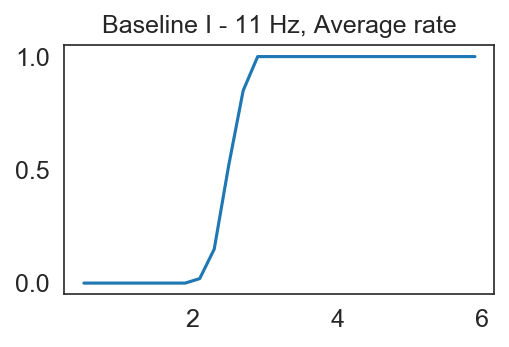

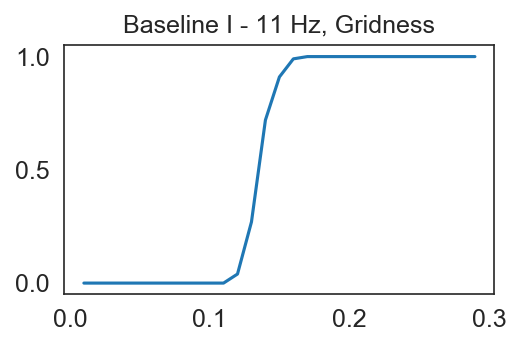

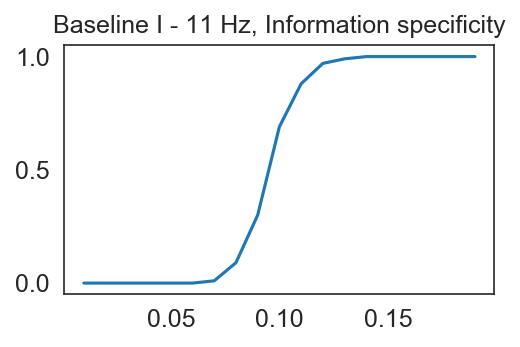

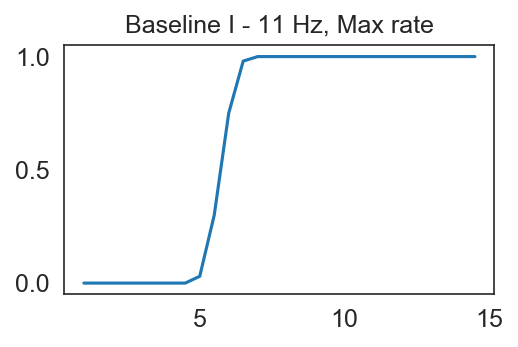

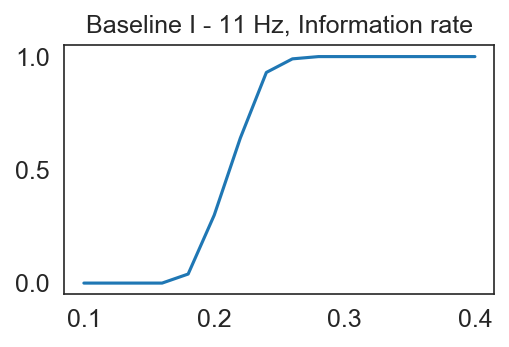

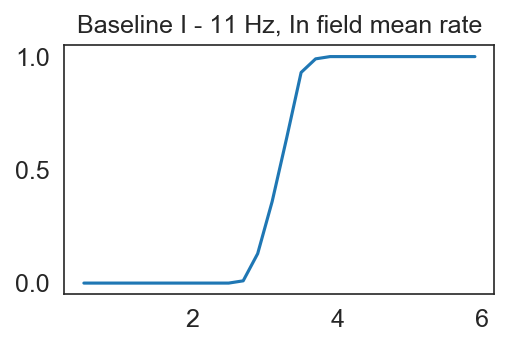

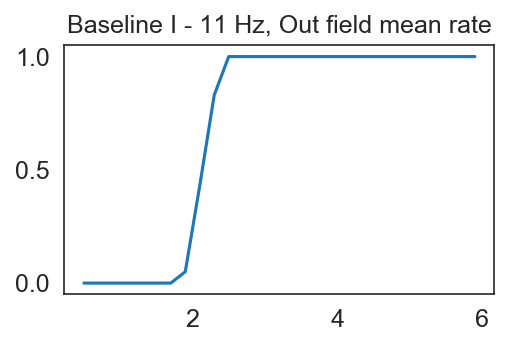

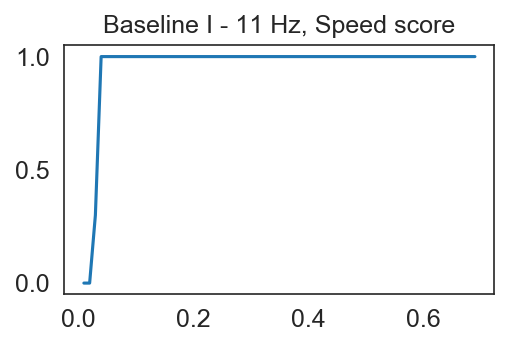

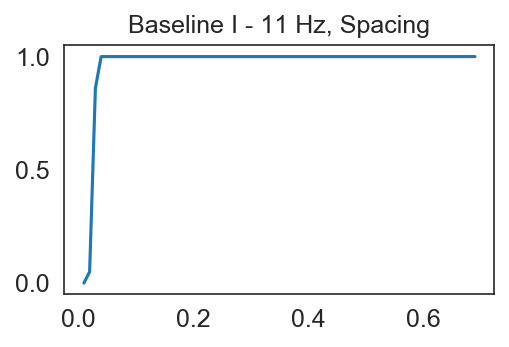

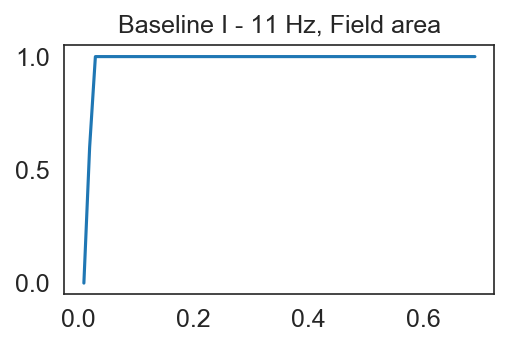

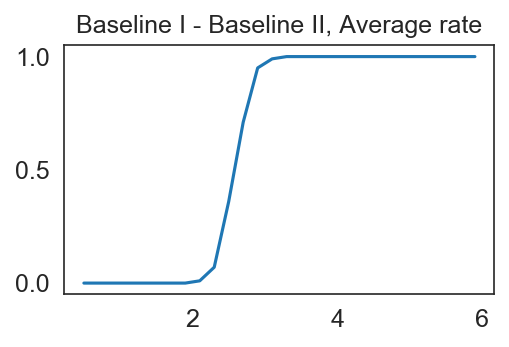

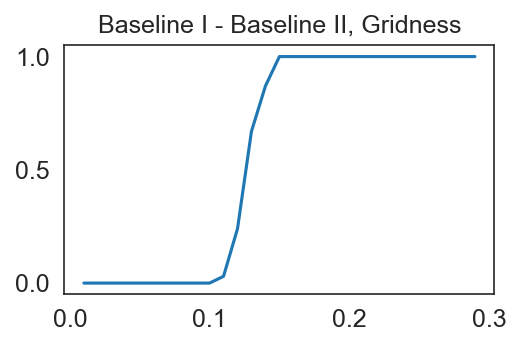

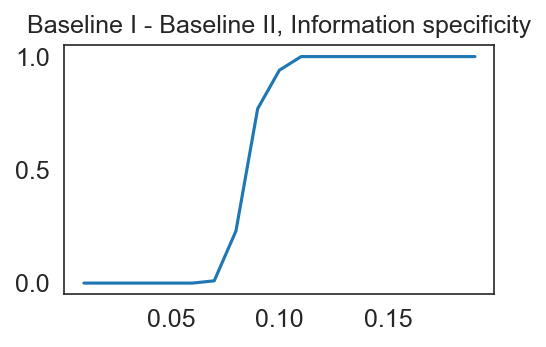

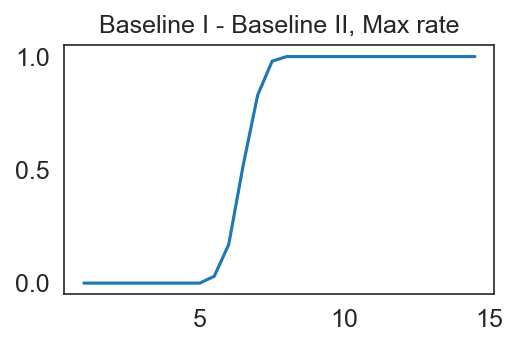

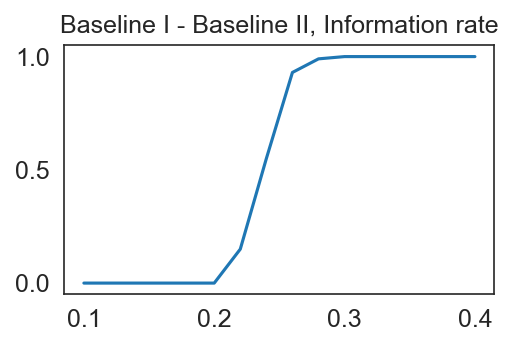

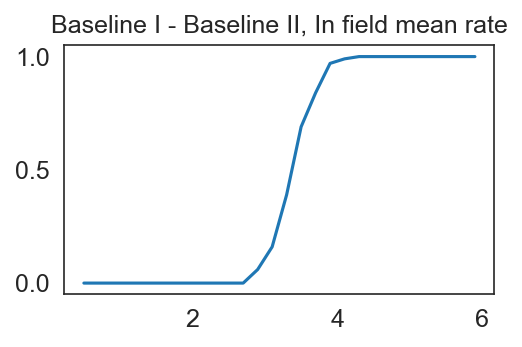

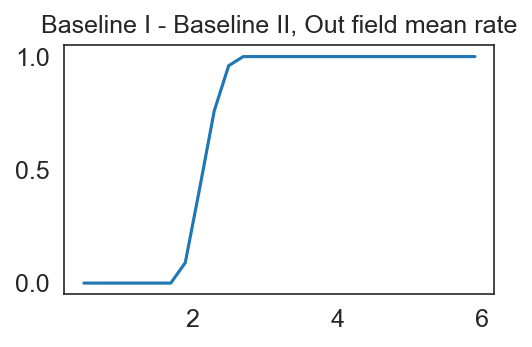

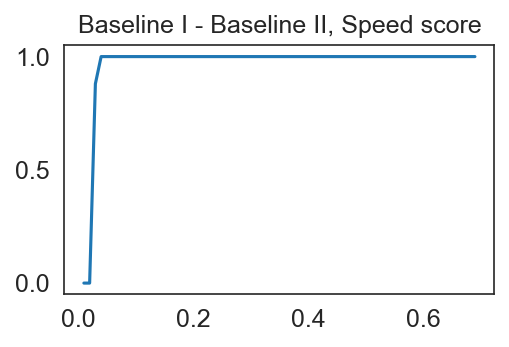

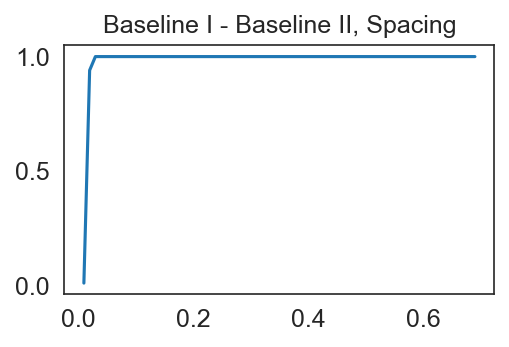

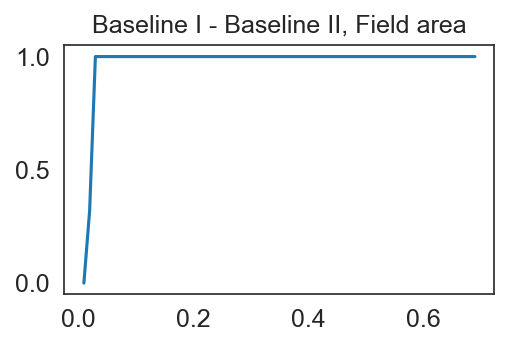

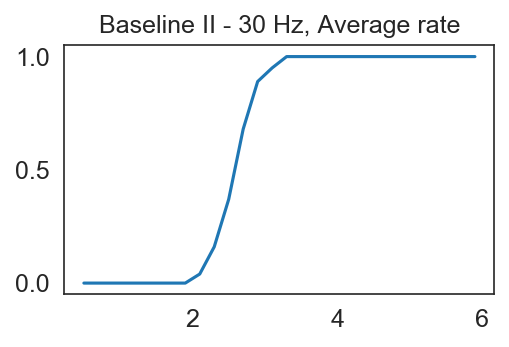

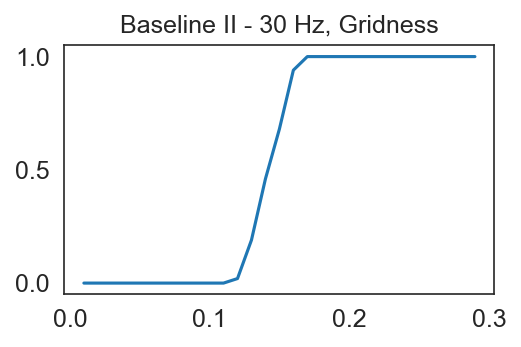

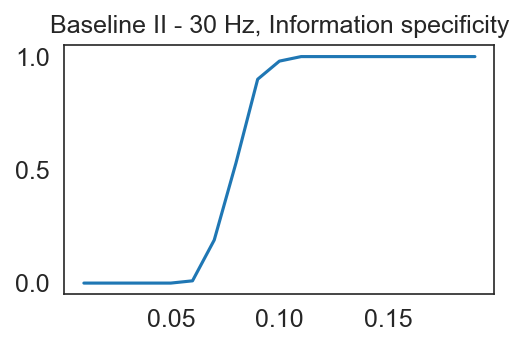

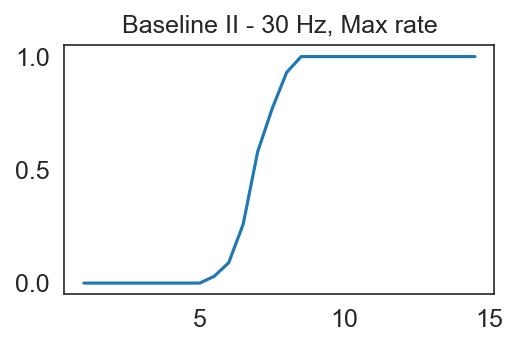

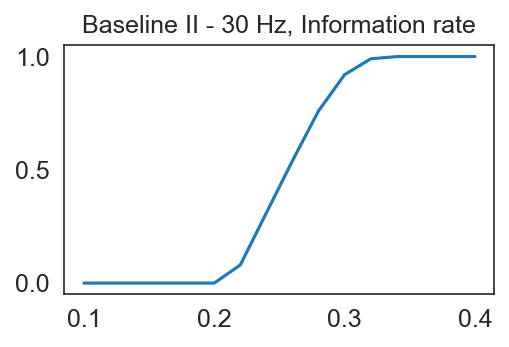

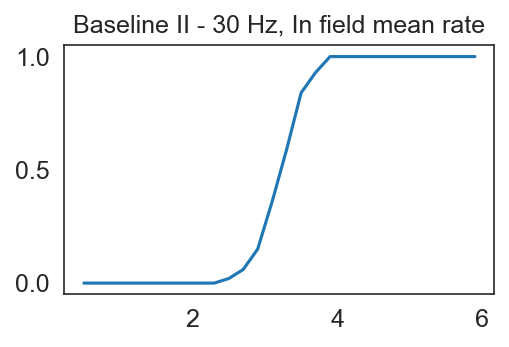

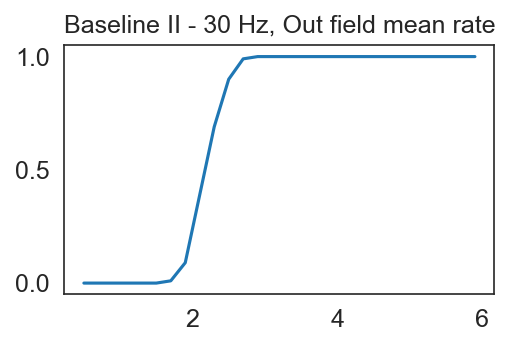

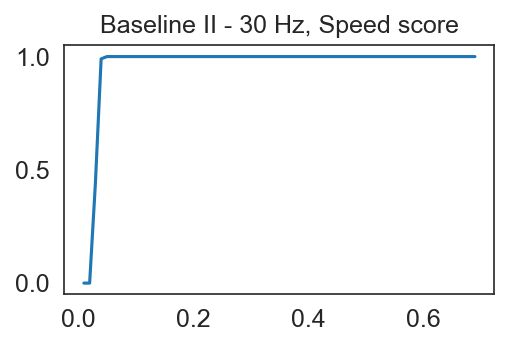

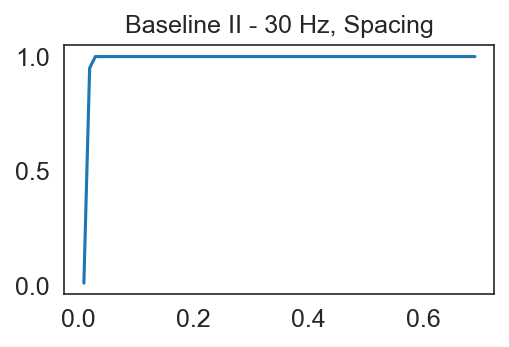

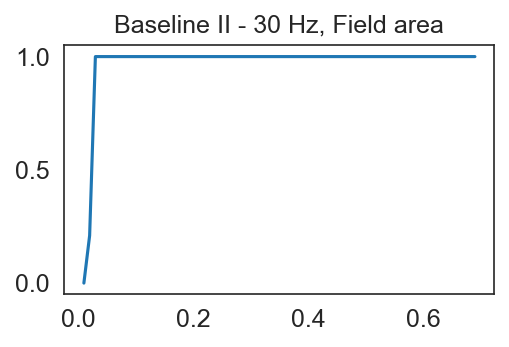

In [146]:
for vs, vals in powers.items():
    for key, val in vals.items():
        plt.figure()
        plt.plot(val['e'], val['p'])
        plt.title(' - '.join(vs) + ', ' + key.replace('_', ' ').capitalize())
        savefig(output_path / 'figures' / f"{'-'.join(vs)}_{key}")

# Store data

In [135]:
np.savez(output_path / 'data' / 'powers.npz', powers)

# Create nice table

In [143]:
effect_size_power_80p = pd.DataFrame()
for vs, vals in powers.items():
    for key, val in vals.items():
        e = interp1d(val['p'], val['e'])(0.8)
        effect_size_power_80p.loc[key.replace('_', ' ').capitalize(), ' - '.join(vs)] = e

In [144]:
effect_size_power_80p

,Baseline I - 11 Hz,Baseline I - Baseline II,Baseline II - 30 Hz
Average rate,2.669697,2.775000,2.814286
Gridness,0.144211,0.136500,0.154615
Information specificity,0.105789,0.091765,0.087297
Max rate,6.108696,6.951613,7.593750
Information rate,0.231034,0.253158,0.285000
In field mean rate,3.410345,3.646667,3.468000
Out field mean rate,2.285000,2.340000,2.404762
Speed score,0.365714,0.029091,0.036545
Spacing,0.029259,0.018495,0.018404
Field area,0.260000,0.358824,0.378481


In [147]:
effect_size_power_80p.to_latex(output_path / "statistics" / "effect_size_power_80p.tex")
effect_size_power_80p.to_csv(output_path / "statistics" / "effect_size_power_80p.csv")

# Estimate required sample size to detect set effect sizes

In [8]:
effect_sizes = {
    'gridness': .1,
    'average_rate': 2, 
    'information_specificity': 0.1,
    'max_rate': 5, 
    'information_rate': 0.2, 
    'in_field_mean_rate': 3, 
    'out_field_mean_rate': 2, 
    'speed_score': 0.1,
    'spacing': 0.05,
    'field_area': 0.05
}

n_samples_ranges = {
    'gridness': (10, 300, 10),
    'average_rate': (10, 300, 10), 
    'information_specificity': (10, 120, 10),
    'max_rate': (10, 120, 10), 
    'information_rate': (10, 120, 10), 
    'in_field_mean_rate': (10, 120, 10), 
    'out_field_mean_rate': (10, 120, 10), 
    'speed_score': (5, 60, 5),
    'spacing': (5, 60, 5),
    'field_area': (5, 60, 5)
}

In [11]:
powers_sample_size = {}
for vs in vss:
    powers_sample_size[vs] = {}
    for key, df in tqdm(results['gridcell'].items(), desc=' - '.join(vs)):
        power, sample_size, effective_sample_size = estimate_sample_size_lmm(
            results['gridcell'][key], *vs, effect_size=effect_sizes[key], n_samples_range=n_samples_ranges[key], key=key)
        powers_sample_size[vs][key] = {'p': power, 's': sample_size, 'es': effective_sample_size}

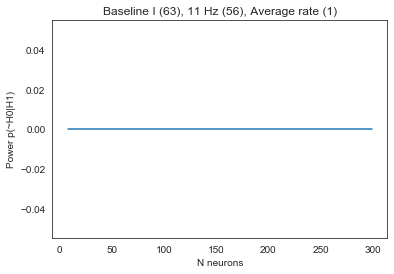

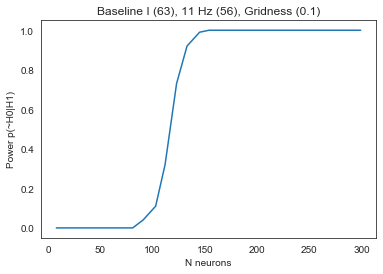

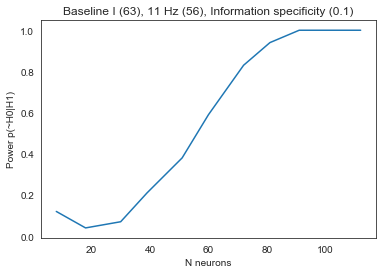

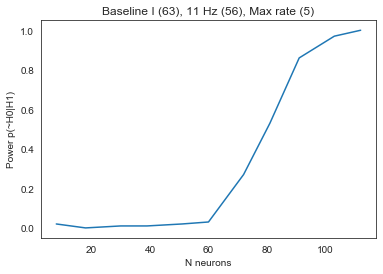

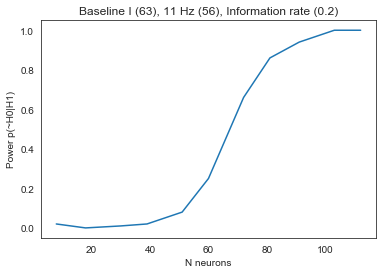

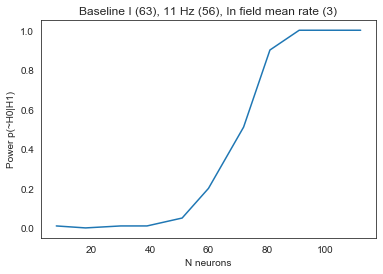

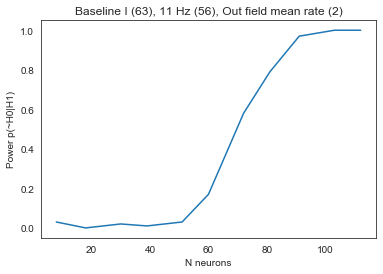

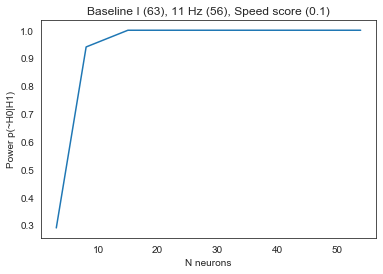

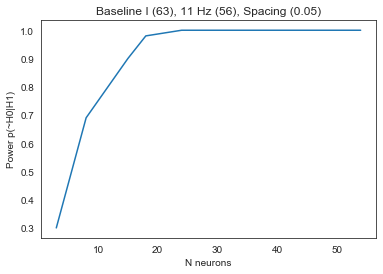

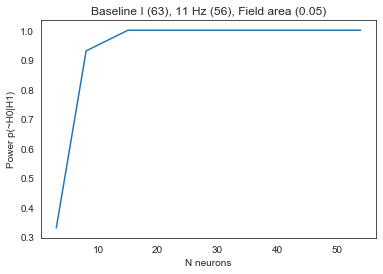

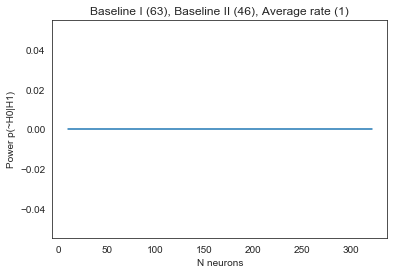

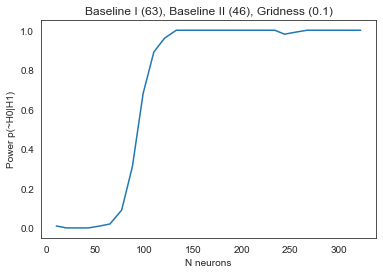

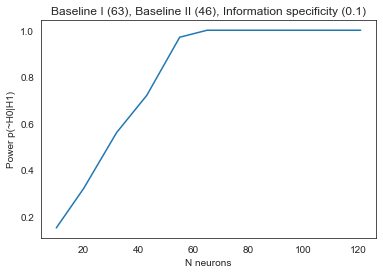

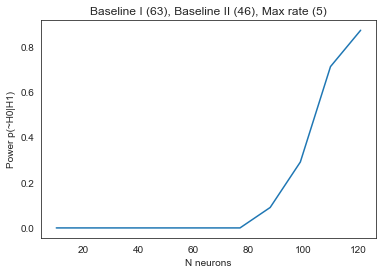

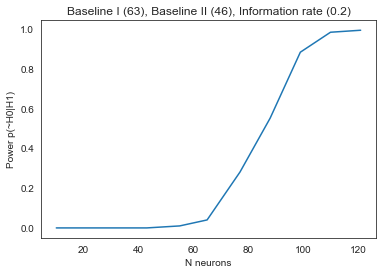

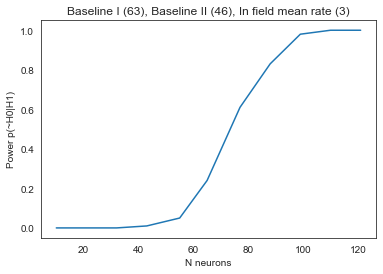

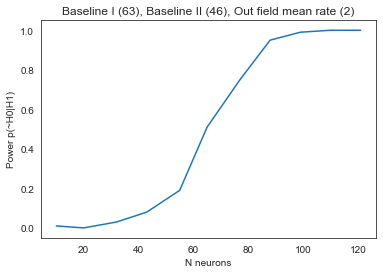

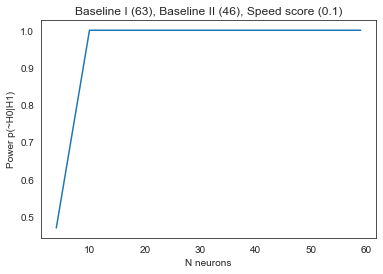

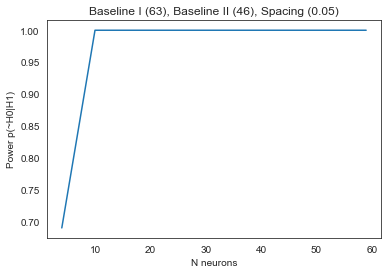

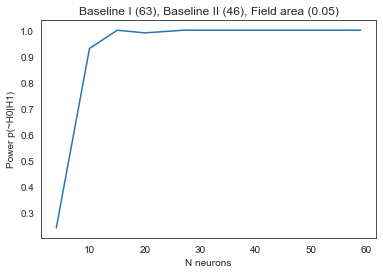

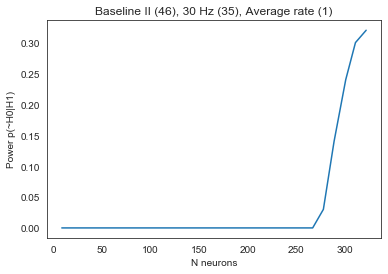

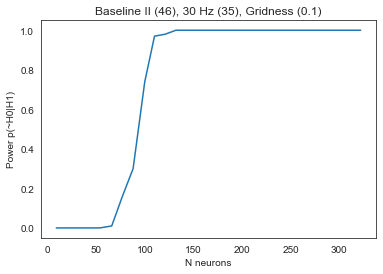

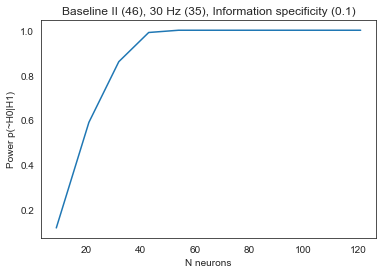

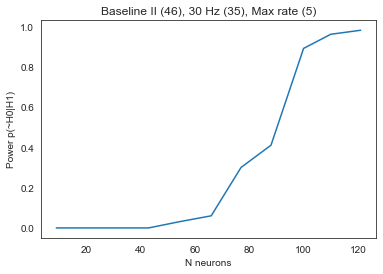

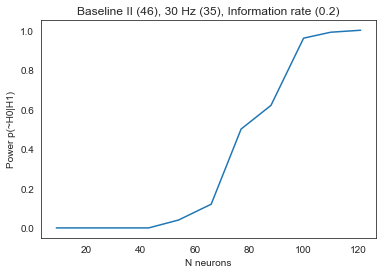

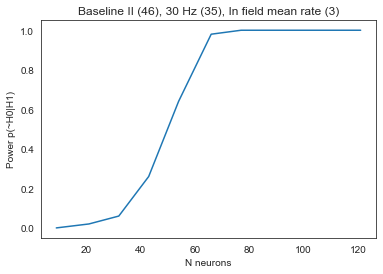

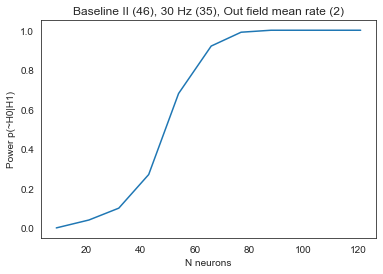

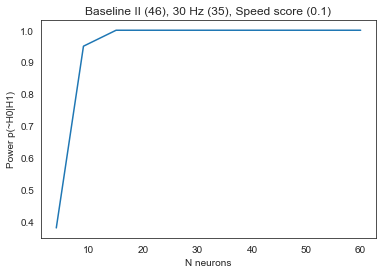

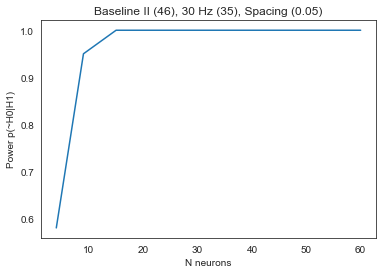

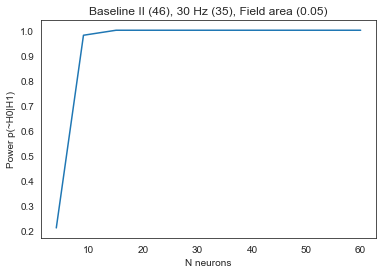

In [12]:
for vs, vals in powers_sample_size.items():
    for key, val in vals.items():
        plt.figure()
        plt.plot(val['es'], val['p'])
        try:
            e = interp1d(val['p'], val['es'])(0.8)
            plt.axvline(e, label=f'N={e:.0f}', color='k')
            plt.axhline(0.8, color='k', alpha=0.1)
            plt.legend()
        except:
            pass
        n1, n2 = results['gridcell'][key][list(vs)].count().values
        plt.title(f"{vs[0]} ({n1}), {vs[1]} ({n2}), {key.replace('_', ' ').capitalize()} ({effect_sizes[key]})")
        plt.ylabel('Power p(~H0|H1)')
        plt.xlabel('N neurons')
        savefig(output_path / 'figures' / f"sample_size_{'-'.join(vs)}_{key}")

In [16]:
sample_size_power_80p = pd.DataFrame()
for vs, vals in powers_sample_size.items():
    for key, val in vals.items():
        try:
            e = interp1d(val['p'], val['es'])(0.8)
        except:
            e = np.nan
        name = f"{key.replace('_', ' ').capitalize()}"
        sample_size_power_80p.loc[name, ' - '.join(vs)] = e

In [17]:
sample_size_power_80p

,Baseline I - 11 Hz,Baseline I - Baseline II,Baseline II - 30 Hz
Average rate,NaN,NaN,NaN
Gridness,126.684211,105.285714,102.608696
Information specificity,70.500000,46.840000,29.555556
Max rate,89.181818,116.187500,97.750000
Information rate,78.300000,96.333333,94.352941
In field mean rate,78.692308,86.500000,59.647059
Out field mean rate,81.555556,79.750000,60.000000
Speed score,6.923077,7.735849,7.684211
Spacing,11.666667,6.129032,6.972973
Field area,6.916667,8.869565,7.831169


# Store data

In [18]:
sample_size_power_80p.to_latex(output_path / "statistics" / f"sample_size_power.tex")
sample_size_power_80p.to_csv(output_path / "statistics" / f"sample_size_power.csv")

In [19]:
np.savez(output_path / 'data' / 'powers_sample_size.npz', powers_sample_size)

# Register in Expipe

In [20]:
action = project.require_action("comparisons-power")

In [21]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-power/data/statistics/sample_size_power.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/statistics/effect_size_power_80p.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/statistics/sample_size_power.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/statistics/effect_size_power_80p.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/data/powers_sample_size.npz',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/data/powers.npz',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/figures/sample_size_Baseline I-Baseline II_speed_score.png',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/figures/sample_size_Baseline I-11 Hz_information_specificity.png',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/figures/Baseline I-11 Hz_field_area.png',
 '/media/storage/expipe/septum-mec/actio

In [22]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_power.ipynb")

# Testing

In [213]:
vs, key = vss[0], 'gridness'

## vary effect size

In [22]:
vs, key = vss[0], 'gridness'
power, effect_size = estimate_power_lmm(results['gridcell'][key], *vs, effect_range=effect_ranges[key], re_formula='label')

Text(0.5, 0, 'Effect size')

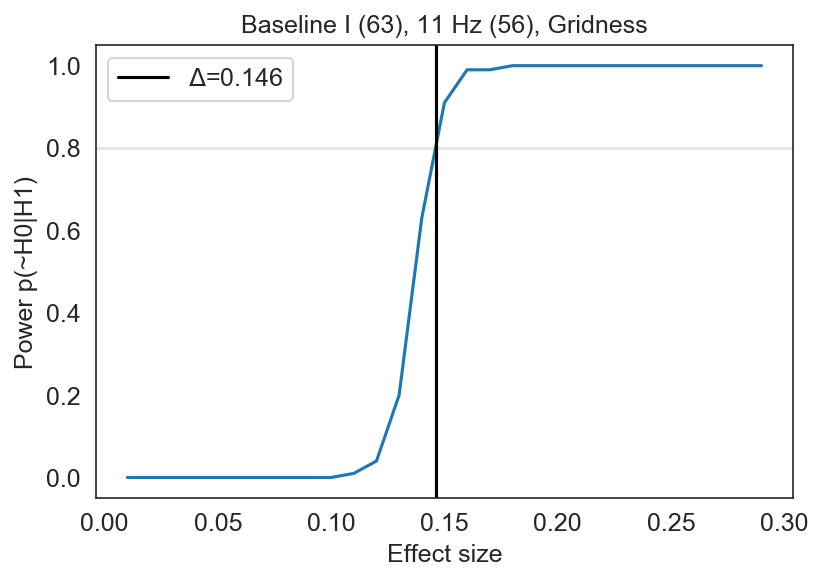

In [27]:
plt.figure()
plt.plot(effect_size, power)
e = interp1d(power, effect_size)(0.8)
plt.axvline(e, label=f'$\\Delta$={e:.3f}', color='k')
plt.axhline(0.8, color='k', alpha=0.1)
plt.legend()
n1, n2 = results['gridcell'][key][list(vs)].count().values
plt.title(f"{vs[0]} ({n1}), {vs[1]} ({n2}), {key.replace('_', ' ').capitalize()}")
plt.ylabel('Power p(~H0|H1)')
plt.xlabel('Effect size')

## vary sample size

In [ ]:
power, sample_size, effective_sample_size = estimate_sample_size_lmm(
    results['gridcell'][key], *vs, effect_size=effect_sizes[key], n_samples_range=(10, 300, 10), key=key)

In [216]:
power, sample_size, effective_sample_size =estimate_sample_size_lmm(
    results['gridcell'][key], *vs, effect_size=effect_sizes[key], n_samples_range=(10, 200, 10), n_repeats=100, key=key)

In [198]:
%%time
power, sample_size, effective_sample_size = estimate_sample_size_lmm_paralell(
    results['gridcell'][key], *vs, effect_size=effect_sizes[key], n_samples_range=(10, 130, 10), n_repeats=100, key=key)

CPU times: user 992 ms, sys: 740 ms, total: 1.73 s
Wall time: 7min 45s


Text(0.5, 0, 'N neurons')

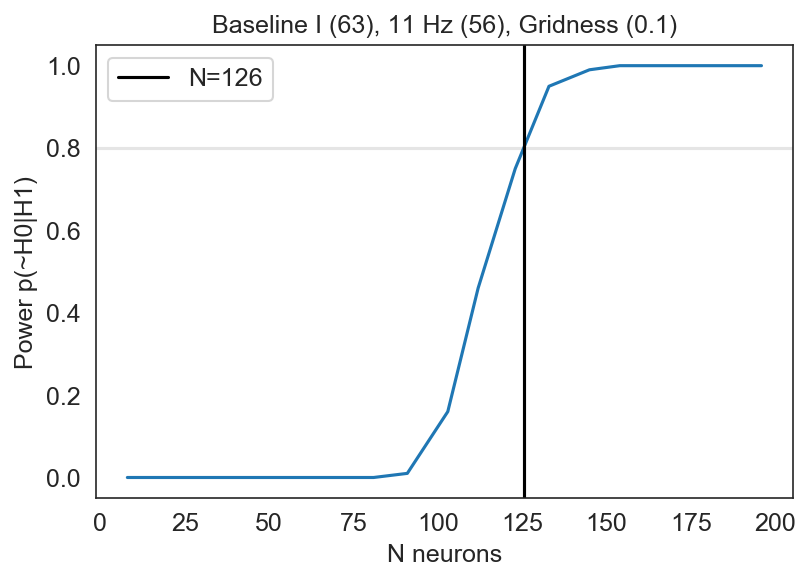

In [226]:
plt.plot(effective_sample_size, power)
estimated_sample_size = interp1d(power, effective_sample_size)(0.8)
plt.axvline(estimated_sample_size, label=f'N={estimated_sample_size:.0f}', color='k')
plt.axhline(0.8, color='k', alpha=0.1)
n1, n2 = results['gridcell'][key][list(vs)].count().values
plt.title(f"{vs[0]} ({n1}), {vs[1]} ({n2}), {key.replace('_', ' ').capitalize()} ({effect_sizes[key]})")
plt.legend()
plt.ylabel('Power p(~H0|H1)')
plt.xlabel('N neurons')
# plt.xlim(0,200)